## Train with rgb loss, and visualize how the loss is being calculated and the views rendered

In [1]:
import time
from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

import os
import sys
sys.path.append('/usr/src/app/spsg/torch')
from utils_spsg.raycast_rgbd.raycast_rgbd import RaycastRGBD

%load_ext autoreload
%autoreload 2

## Setup

In [2]:
config.merge_from_file('configs/front3d_train_3d.yaml')

model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)

model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")


-----------------------------------------
unet_output_channels 16
unet_fetures 16


In [3]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('output')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

# TODO: move to checkpointer?
if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])
    
# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10367060
Number of Trainable Parameters: 10367060


# Train

In [4]:
# Switch training mode
# self.model.switch_training()
print(len(dataloader))
model.switch_training()
iteration = 0
iteration_end = time.time()


for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue
    
    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()
    rgb_loss = 0.0
    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if(loss_name == "rgb"):
                # print("loss_name: {}, loss: {}".format(loss_name, loss))
                rgb_loss = loss
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()
    
    # Save checkpoint
    if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
        checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)
    
    last_training_stage = model.set_current_training_stage(iteration)
    
    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")
    
    iteration += 1
    iteration_end = time.time()

    print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss), end="")
    if iteration%20 == 0:
        print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss))
        
    # if idx>4:
        # break


300


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:195: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

iteration: 11, total_loss: 8.194859504699707, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:302: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:329: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 20, total_loss: 121.93452453613281, rgb_loss:0.0
iteration: 36, total_loss: 71.23898315429688, rgb_loss:0.00

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:412: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:509: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 40, total_loss: 405.4403381347656, rgb_loss:56.51161575317383
iteration: 60, total_loss: 194.12673950195312, rgb_loss:26.477706909179688
iteration: 80, total_loss: 164.48260498046875, rgb_loss:19.539028167724612
iteration: 100, total_loss: 142.1913604736328, rgb_loss:15.875548362731934
iteration: 120, total_loss: 135.1991424560547, rgb_loss:15.4795703887939454
iteration: 140, total_loss: 136.4784393310547, rgb_loss:14.7966918945312536
iteration: 160, total_loss: 79.46766662597656, rgb_loss:16.4908790588378946
iteration: 180, total_loss: 156.7335205078125, rgb_loss:14.7044849395751953
iteration: 200, total_loss: 138.3604736328125, rgb_loss:14.4240722656253496
iteration: 220, total_loss: 117.6689453125, rgb_loss:14.5521583557128963099
iteration: 240, total_loss: 119.88504791259766, rgb_loss:15.019348144531252
iteration: 260, total_loss: 132.63525390625, rgb_loss:14.585566520690918051
iteration: 280, total_loss: 153.25576782226562, rgb_loss:14.552283287048342
iteration: 300, to

## Get geometry and color predictions (sparse)

In [5]:
print(results.keys())
print(results['frustum'].keys())
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)

dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([100204, 1])
rgb_sparse shape:  torch.Size([100204, 3])


## Convert to dense predictions (256^3)

In [180]:

# from .lib.modeling.frustum.rgb_loss import rgb_loss
# print(results.keys())
# print(results['frustum'].keys())
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)

aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)


geometry_sparse shape:  torch.Size([100204, 1])
rgb_sparse shape:  torch.Size([100204, 3])
aux_views shape:  torch.Size([1, 4, 3, 240, 320])
cam_poses shape:  torch.Size([1, 4, 1, 4, 4])


## Render using spsg
### Get Dense Predictions from Sparse Tensors

In [181]:
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
import loss as loss_util

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.0,0.0]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,-0.1364133358001709]


## Get Tensors for raycaster

In [354]:
from pytorch3d.renderer import (
    look_at_view_transform,
)
def homogeneous_transform(R,t):
    last_row = torch.FloatTensor([[0,0,0,1]]).unsqueeze(0)
    T = torch.cat((R,t),dim=2)
    return torch.cat((T,last_row),dim=1)

truncation = 1.5
sdf = geometry.unsqueeze(0).unsqueeze(0)
sdf = torch.clamp(sdf,0.0,3.0)
sdf-=1.5

colors = rgb.permute(1,2,3,0).unsqueeze(0)
print("sdf shape: ", sdf.shape)
print("colors shape: ", colors.shape)

locs = torch.nonzero(torch.abs(sdf[:,0]) < truncation)
print("locs shape: ", locs.shape)

locs = torch.cat([locs[:,1:], locs[:,:1]],1).contiguous()
print("locs shape: ", locs.shape)

vals = sdf[locs[:,-1],:,locs[:,0],locs[:,1],locs[:,2]].contiguous()
colors = colors[locs[:,-1],locs[:,0],locs[:,1],locs[:,2],:].float() #/255.0
print("vals shape: ", vals.shape)
print("vals range: [{},{}]".format(torch.min(vals),torch.max(vals)))
print("colors shape: ", colors.shape)
print("colors range: [{},{}]".format(torch.min(colors),torch.max(colors)))
intrinsics = torch.FloatTensor([[277.1281435, 311.76912635, 159.0, 119.0]]).to(device)
# # view_matrix = 

sdf shape:  torch.Size([1, 1, 256, 256, 256])
colors shape:  torch.Size([1, 256, 256, 256, 3])
locs shape:  torch.Size([99841, 4])
locs shape:  torch.Size([99841, 4])
vals shape:  torch.Size([99841, 1])
vals range: [-1.4997206926345825,1.4999475479125977]
colors shape:  torch.Size([99841, 3])
colors range: [0.0,1.0]


## Raycast to render views

=====================CREATING RAYCAST RGBD MODEL=====================
raycast_color:  torch.Size([1, 240, 320, 3])
raycast_color1:  (240, 320, 3)
raycast_color1 range: [-inf,1.0]
target_normals range: [-1.0,1.0]
raycast_color1 range: [0,255]
(240, 320, 3)


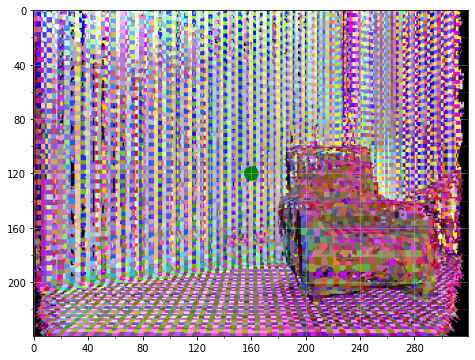


raycast_normal_np range: [0,254]
(240, 320, 3)


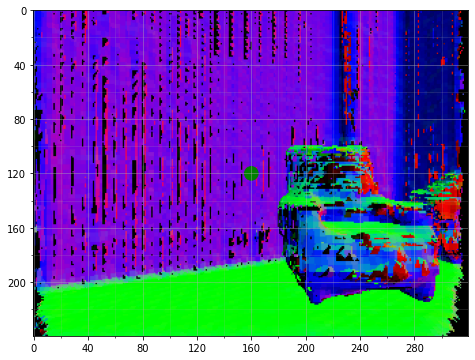

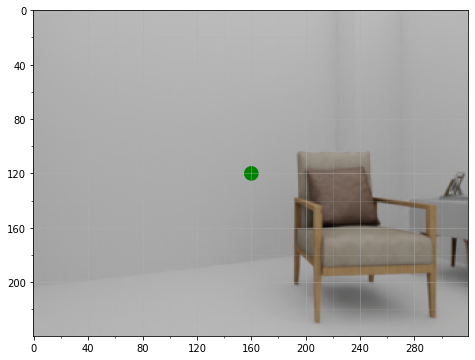

In [355]:
import cv2
import matplotlib.pyplot as plt
from plot_image_grid import plot_image
from utils_spsg.raycast_rgbd.raycast_rgbd import RaycastRGBD
from PIL import Image

# 14.399999999999999,30.700000000000024,-72.40000000000003
input_dim = (256, 256, 256)
batch_size = 1
style_width = 320
style_height = 240
voxelsize = 0.03
raycast_depth_max = 6.0
ray_increment = 0.3 * truncation
thresh_sample_dist = 50.5 * ray_increment
max_num_locs_per_sample = 640000

raycaster_rgbd = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize, 
                             thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)

R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
t0 = torch.FloatTensor([[20.0,128.0,128.0]])
view_matrix = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)

target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

raycast_color_np = raycast_color[0].detach().cpu().numpy()
raycast_normal_np = raycast_normal[0].detach().cpu().numpy()
print("raycast_color: ",raycast_color.shape)

print("raycast_color1: ",raycast_color_np.shape)
print("raycast_color1 range: [{},{}]".format(np.amin(raycast_color_np), np.amax(raycast_color_np)))
print("target_normals range: [{},{}]".format(torch.min(target_normals), torch.max(target_normals)))
raycast_color_np[raycast_color_np<0.0] = 0.0
raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
print("raycast_color1 range: [{},{}]".format(np.amin(raycast_color_np), np.amax(raycast_color_np)))
print(raycast_color_np.shape)
plot_image(raycast_color_np)
raycast_normal_np[raycast_normal_np<0.0] = 0.0
raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
print("\nraycast_normal_np range: [{},{}]".format(np.amin(raycast_normal_np), np.amax(raycast_normal_np)))
print(raycast_normal_np.shape)
plot_image(raycast_normal_np)

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

In [361]:
# Base transform (Original transform to render images in the view frustum)
R0, t0 = look_at_view_transform(dist=-180, elev=0, azim=90)
t0 = torch.FloatTensor([[0.0,128.0,128.0]])

T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0))
print("\T_C1W: ", T_C1W)

# Ground truth camera pose in the dataset
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')['camera2world']
print("cam2world", cam2world.shape)
t1 = cam2world[:-1,-1]/voxelsize
R1 = cam2world[:3,:3]
t1 = torch.from_numpy(t1).type(torch.FloatTensor).unsqueeze(0)
R1 = torch.from_numpy(R1).type(torch.FloatTensor).unsqueeze(0)
T_GC1 = homogeneous_transform(R1,t1.transpose(0,1).unsqueeze(0))
print("\nT_GC1: ", T_GC1)

# Auxiliary views:
# View 1
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')['camera2world']
t2 = cam2world[:-1,-1]/voxelsize
R2 = cam2world[:3,:3]
t2 = torch.from_numpy(t2).type(torch.FloatTensor).unsqueeze(0)
R2 = torch.from_numpy(R2).type(torch.FloatTensor).unsqueeze(0)
T_GC2 = homogeneous_transform(R2,t2.transpose(0,1).unsqueeze(0))
print("\nT_GC2: ", T_GC2 )

# Compute transform to auxiliary view
T_C2W=torch.zeros_like(T_C1W) 
T_C2W[0] = torch.inverse(T_GC2[0]) @ T_GC1[0] @ T_C1W
print("T_C2W: ", T_C2W )

# View 2
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0018.npz')['camera2world']
t3 = cam2world[:-1,-1]/voxelsize
R3 = cam2world[:3,:3]
t3 = torch.from_numpy(t3).type(torch.FloatTensor).unsqueeze(0)
R3 = torch.from_numpy(R3).type(torch.FloatTensor).unsqueeze(0)
T_GC3 = homogeneous_transform(R3,t3.transpose(0,1).unsqueeze(0))
print("\nT_GC3: ", T_GC3 )

# Compute transform to auxiliary view
T_C3W=torch.zeros_like(T_C1W) 
T_C3W[0] = torch.inverse(T_GC3[0]) @ T_GC1[0] @ T_C1W
print("T_C3W: ", T_C3W )

# View 2
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0021.npz')['camera2world']
t4 = cam2world[:-1,-1]/voxelsize
R4 = cam2world[:3,:3]
t4 = torch.from_numpy(t4).type(torch.FloatTensor).unsqueeze(0)
R4 = torch.from_numpy(R4).type(torch.FloatTensor).unsqueeze(0)
T_GC4 = homogeneous_transform(R4,t4.transpose(0,1).unsqueeze(0))
print("\nT_GC4: ", T_GC4 )

# Compute transform to auxiliary view
T_C4W=torch.zeros_like(T_C1W) 
T_C4W[0] = torch.inverse(T_GC4[0]) @ T_GC1[0] @ T_C1W
print("T_C4W: ", T_C4W )

\T_C1W:  tensor([[[-4.3711e-08,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.2800e+02],
         [-1.0000e+00,  0.0000e+00, -4.3711e-08,  1.2800e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
cam2world (4, 4)

T_GC1:  tensor([[[ 8.9057e-01, -2.8493e-06,  4.5484e-01, -1.1823e+02],
         [-4.5484e-01, -5.5901e-06,  8.9057e-01,  8.8851e+01],
         [ 5.1204e-09, -1.0000e+00, -6.2744e-06,  2.5000e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

T_GC2:  tensor([[[ 9.1425e-01, -2.5458e-06,  4.0515e-01, -9.0808e+01],
         [-4.0515e-01, -5.7347e-06,  9.1425e-01,  1.0377e+02],
         [-4.0992e-09, -1.0000e+00, -6.2744e-06,  2.5000e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
T_C2W:  tensor([[[-5.5023e-02, -3.3602e-07,  9.9849e-01, -1.1987e+01],
         [-9.2796e-09,  1.0000e+00,  3.3602e-07,  1.2800e+02],
         [-9.9849e-01,  9.2227e-09, -5.5023e-02,  1.0305e+02

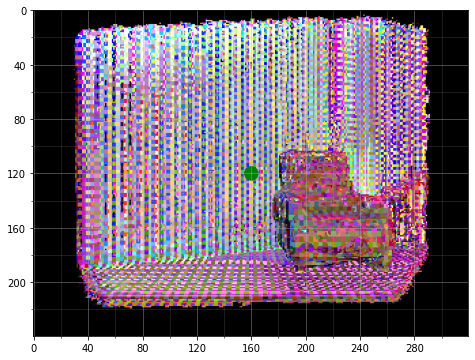

(240, 320, 3)


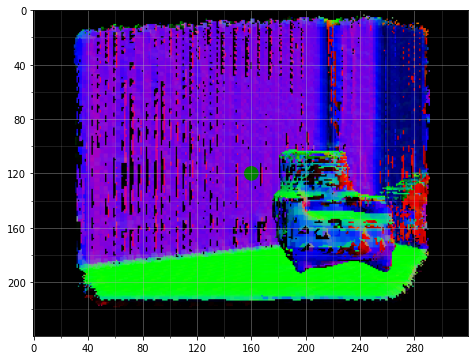

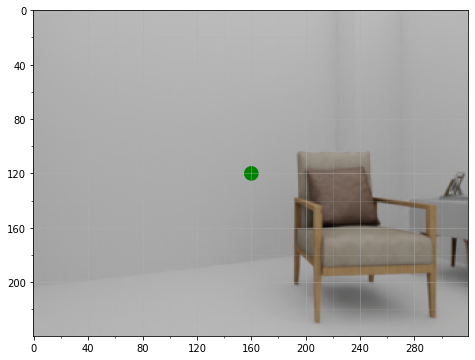

In [362]:
view_matrix = homogeneous_transform(T_C1W[:,:3,:3],T_C1W[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

raycast_color_np = raycast_color[0].detach().cpu().numpy()
raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

raycast_color_np[raycast_color_np<0.0] = 0.0
raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
plot_image(raycast_color_np)
raycast_normal_np[raycast_normal_np<0.0] = 0.0
raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
print(raycast_normal_np.shape)
plot_image(raycast_normal_np)

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

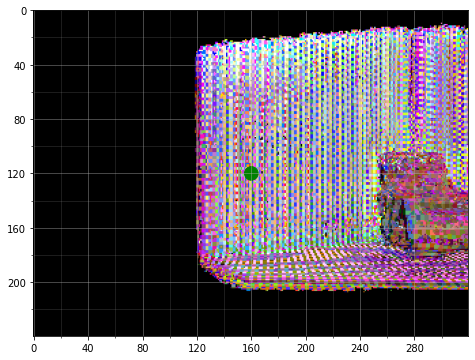

(240, 320, 3)


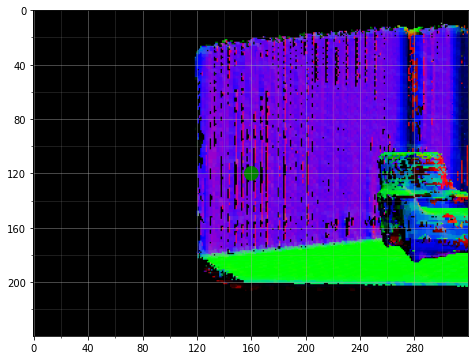

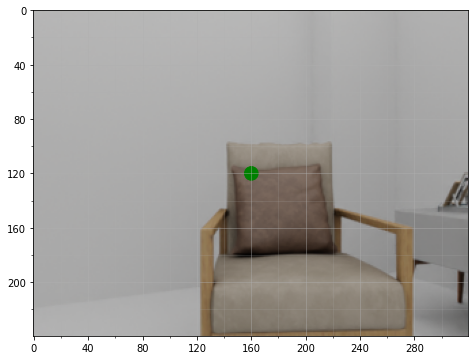

In [363]:
view_matrix = homogeneous_transform(T_C2W[:,:3,:3],T_C2W[:,:3,-1].transpose(0,1).unsqueeze(0)).to(device)

target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster_rgbd(locs, vals, colors.contiguous(), target_normals, view_matrix, intrinsics)
raycast_color = torch.fliplr(raycast_color[0]).unsqueeze(0)
raycast_normal = torch.fliplr(raycast_normal[0]).unsqueeze(0)

raycast_color_np = raycast_color[0].detach().cpu().numpy()
raycast_normal_np = raycast_normal[0].detach().cpu().numpy()

raycast_color_np[raycast_color_np<0.0] = 0.0
raycast_color_np = (255.0*raycast_color_np).astype(np.uint8)
plot_image(raycast_color_np)
raycast_normal_np[raycast_normal_np<0.0] = 0.0
raycast_normal_np = (255.0*raycast_normal_np).astype(np.uint8)
print(raycast_normal_np.shape)
plot_image(raycast_normal_np)

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
plot_image(input_img)

## Perform one loss pass visualizing the predicted colored geometry from different views and how the loss is computed

rendered_img range: [0.0,0.9999538660049438]
mean:  tensor(0.6483, device='cuda:0', grad_fn=<MeanBackward0>)


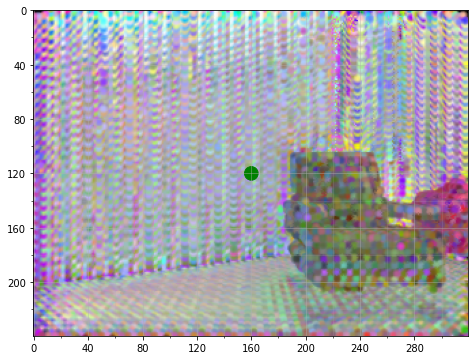

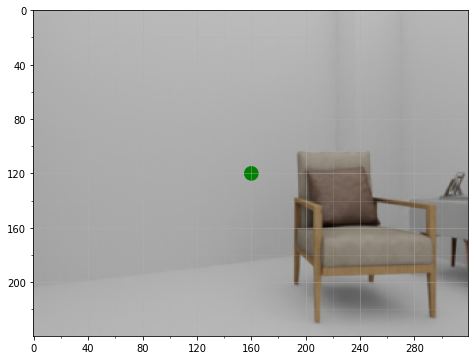

loss:  tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>)
rendered_img range: [0.0,0.9999947547912598]
mean:  tensor(0.6036, device='cuda:0', grad_fn=<MeanBackward0>)


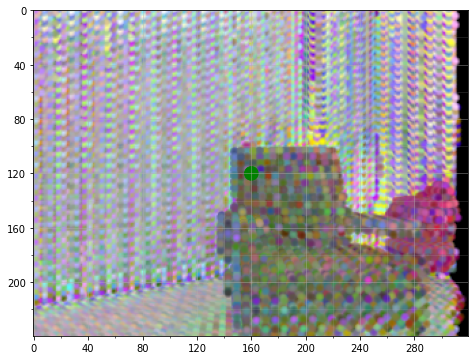

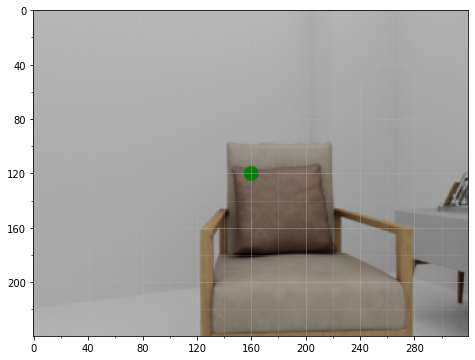

loss:  tensor(0.0343, device='cuda:0', grad_fn=<DivBackward0>)
rendered_img range: [0.0,0.9999935626983643]
mean:  tensor(0.6033, device='cuda:0', grad_fn=<MeanBackward0>)


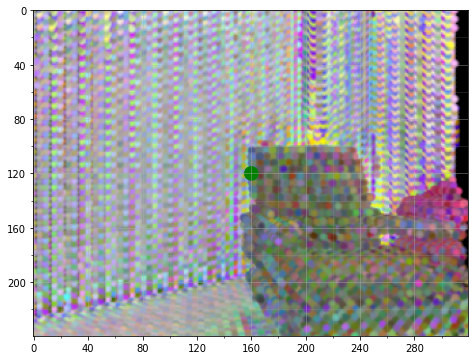

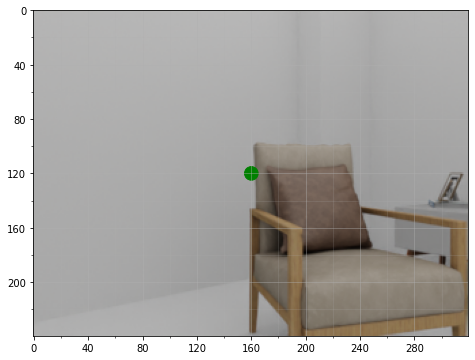

loss:  tensor(0.0334, device='cuda:0', grad_fn=<DivBackward0>)
rendered_img range: [0.0,0.9999991655349731]
mean:  tensor(0.3390, device='cuda:0', grad_fn=<MeanBackward0>)


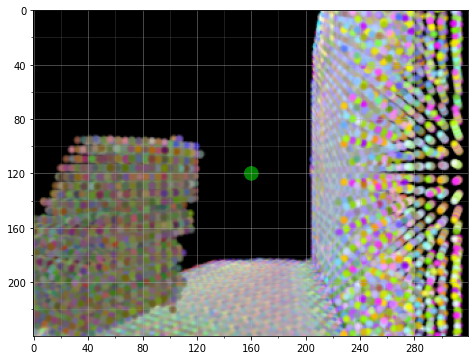

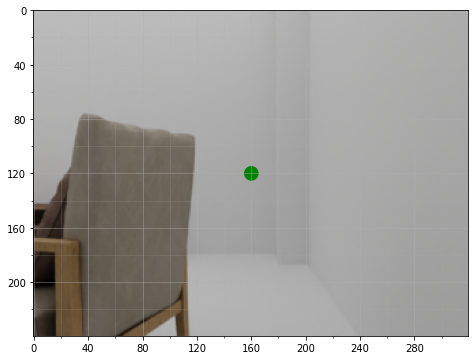

loss:  tensor(0.0444, device='cuda:0', grad_fn=<DivBackward0>)


In [115]:
from lib.modeling.frustum.rgb_loss import RGBLoss

rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, aux_views, cam_poses.to(device), debug=True)

# Save Rendering

In [9]:
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.0,0.0]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,0.0]


In [11]:
def adjust_intrinsic(intrinsic: np.array, intrinsic_image_dim: Tuple, image_dim: Tuple) -> np.array:
    if intrinsic_image_dim == image_dim:
        return intrinsic

    intrinsic_return = np.copy(intrinsic)

    height_after = image_dim[1]
    height_before = intrinsic_image_dim[1]

    width_after = image_dim[0]
    width_before = intrinsic_image_dim[0]

    intrinsic_return[0, 0] *= float(width_after) / float(width_before)
    intrinsic_return[1, 1] *= float(height_after) / float(height_before)

    # account for cropping/padding here
    intrinsic_return[0, 2] *= float(width_after - 1) / float(width_before - 1)
    intrinsic_return[1, 2] *= float(height_after - 1) / float(height_before - 1)

    return intrinsic_return


# Generate Mesh and Render
# Prepare intrinsic matrix.
color_image_size = (320, 240)
depth_image_size = (160, 120)
front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()

print('\n camera_instrinsics: \n', front3d_intrinsic)
camera2frustum = compute_camera2frustum_transform(front3d_intrinsic.cpu(), torch.tensor(images.size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)
print("frustum2camera: ", frustum2camera)


 camera_instrinsics: 
 tensor([[138.5641,   0.0000,  79.5000,   0.0000],
        [  0.0000, 138.5641,  59.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
frustum2camera:  tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


In [37]:
from typing import Union, Tuple, Optional
import os
import marching_cubes as mc
from lib.utils.transform import coords_multiplication
from lib.visualize import io, utils

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)

def write_distance_field2(distance_field: Union[np.array, torch.Tensor], labels: Optional[Union[np.array, torch.Tensor]],
                         output_file: os.PathLike, iso_value: float = 1.0, truncation: float = 3.0,
                         color_palette=None, transform=None) -> None:
    if isinstance(distance_field, torch.Tensor):
        distance_field = distance_field.detach().cpu().numpy()

    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    vertices, colors, triangles = get_mesh_with_colors2(distance_field, labels, iso_value, truncation,)

    if transform is not None:
        if isinstance(transform, torch.Tensor):
            transform = transform.detach().cpu().numpy()

        vertices = coords_multiplication(transform, vertices)

    io.write_ply(vertices, colors, triangles, output_file)




def get_mesh_with_colors2(distance_field: np.array, colors: np.array, iso_value: float = 1.0,
                         truncation: float = 3.0) -> Tuple[np.array, np.array, np.array]:
    print(distance_field.shape)
    print(colors.shape)
    
    vertices, triangles = mc.marching_cubes_color(distance_field, colors, iso_value, truncation)
    colors = vertices[..., 3:]
    vertices = vertices[..., :3]

    return vertices, colors, triangles



In [39]:
write_distance_field2(geometry, rgb.permute(1,2,3,0)*255, "out/mesh_color.ply", transform=frustum2camera)

(256, 256, 256)
(256, 256, 256, 3)


In [10]:
surface_mask = geometry.squeeze() < 1.0
points_rgb = rgb[:,surface_mask].transpose(0,1)
points = surface_mask.squeeze().nonzero()

points = points.type(torch.FloatTensor)
points*=0.03
center = torch.FloatTensor([3.825+0.00,3.825-0.00,3.825-0.0])

points-=center
print(surface_mask.shape)
print(points_rgb.shape)
print(points.shape)
print("points values: [{},{}]".format(torch.max(points), torch.min(points)))

torch.Size([256, 256, 256])
torch.Size([35555, 3])
torch.Size([35555, 3])
points values: [1.7549998760223389,-1.5450000762939453]
